# **Tugas Akhir PCDVK: Smart Waste Classifier (Organik vs Anorganik)**

Anggota:
- Aufii Fathin Nabila (235150200111002)<br>
- Dwi Cahya Maulani (235150201111003)

## **Overview Project**

### **1. Tujuan**

Tujuan dari proyek ini adalah membangun sebuah sistem klasifikasi sampah menjadi dua kategori utama, yaitu **organik** dan **anorganik**, dengan menggabungkan teknik **Pengolahan Citra Digital (PCD)** dan **Visi Komputer (VK)**.
Sistem ini dirancang untuk menunjukkan pipeline lengkap mulai dari **preprocessing citra**, **ekstraksi fitur**, hingga **klasifikasi menggunakan CNN**, serta visualisasi evaluasi seperti grafik performa dan confusion matrix.

Pendekatan ini diharapkan mampu memberikan pemahaman praktis mengenai implementasi metode PCD dan CNN sekaligus menganalisis akurasi model dalam mengidentifikasi jenis sampah.


### **2. Dataset**

Dataset yang digunakan adalah **Waste Classification Data** yang tersedia secara publik di Kaggle:

🔗 [https://www.kaggle.com/datasets/techsash/waste-classification-data](https://www.kaggle.com/datasets/techsash/waste-classification-data)



### **3. Pipeline Sistem**

#### **A. Preprocessing (PCD)**

* **Segmentasi untuk remove background** menggunakan GrabCut
* **Resize** gambar ke ukuran 256×256 piksel
* **Color Space**, konversi citra ke HSV
* **Smoothing** dengan Gaussian + Median Blur untuk mengurangi noise
* (Untuk CNN) **Normalisasi** piksel ke rentang [0–1] dan augmentasi data (rotasi, shift, zoom, flip)

#### **B. Ekstraksi Fitur (PCD)**

* Fitur **warna**: mean, std, dan histogram HSV
* Mengambil fitur **tekstur** dengan GLCM (contrast, correlation, energy, homogeneity)
* Fitur **bentuk**: area ratio, solidity, circularity dari mask foreground
* Menggabungkan semua fitur menjadi satu vektor fitur per citra

#### **C. Klasifikasi (VK)**

* Model CNN dibuat dengan **3 blok Conv2D + MaxPooling**, dilanjutkan **GlobalAveragePooling** dan **Dense**
* Melatih model menggunakan **categorical crossentropy** dan **optimizer Adam**
* Mengevaluasi model melalui grafik **akurasi** dan **loss** train/validation
* Menampilkan contoh **hasil prediksi**

In [8]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob, random
from sklearn.model_selection import train_test_split

PATH FILE

In [9]:
base_path = "."
class_folders = ["DATASET/ANORGANIK", "DATASET/ORGANIK"]

BACKGROUND REMOVAL

In [10]:
def remove_background(image):
    h, w = image.shape[:2]
    rect = (10, 10, w-20, h-20)

    mask = np.zeros((h, w), np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(image, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)

    # 0 & 2 = background, 1 & 3 = foreground
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # apply mask ke image → hasil remove background
    result = image * mask2[:, :, np.newaxis]

    return result, mask2    # ← kembalikan 2 nilai

PREPROCESSING


KELAS: DATASET/ANORGANIK


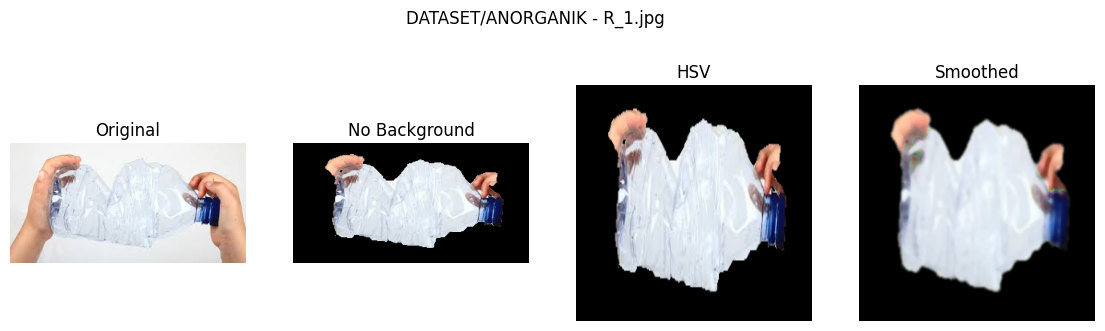

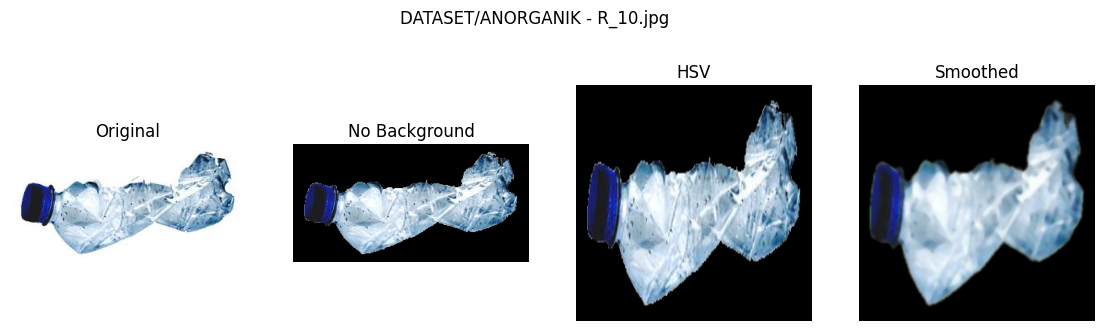

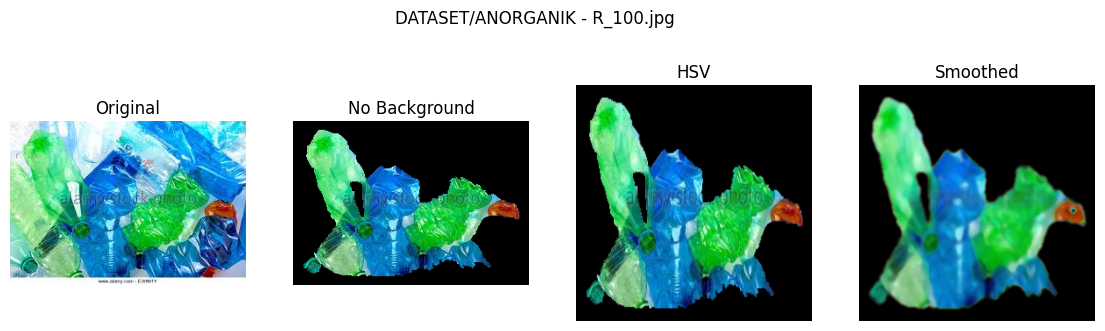


KELAS: DATASET/ORGANIK


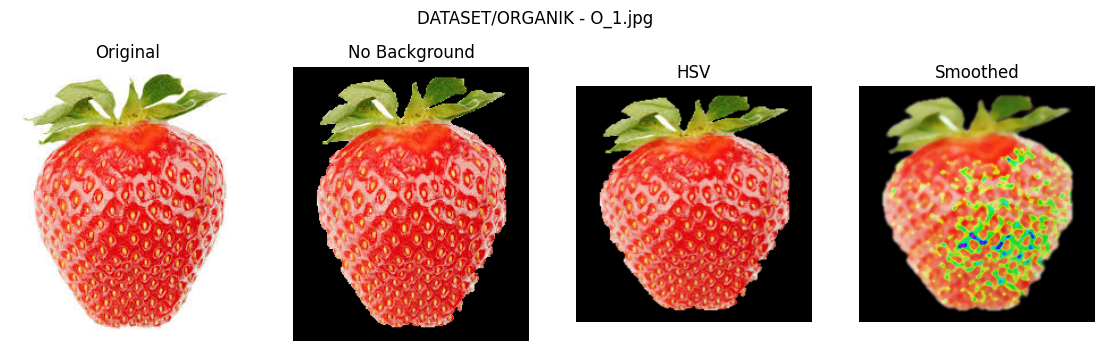

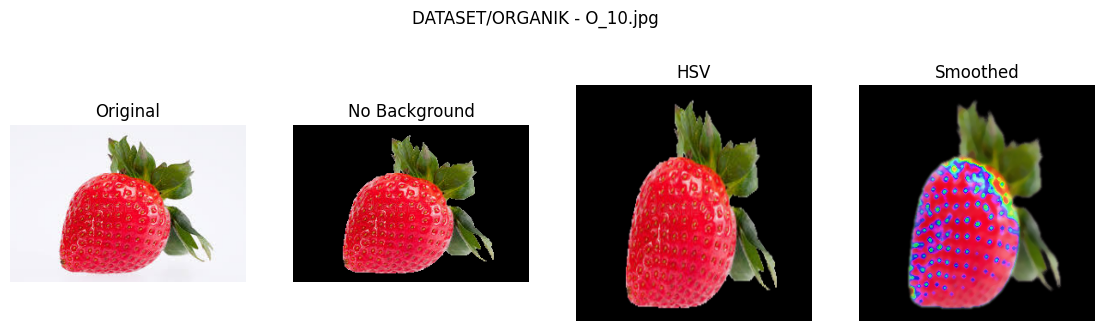

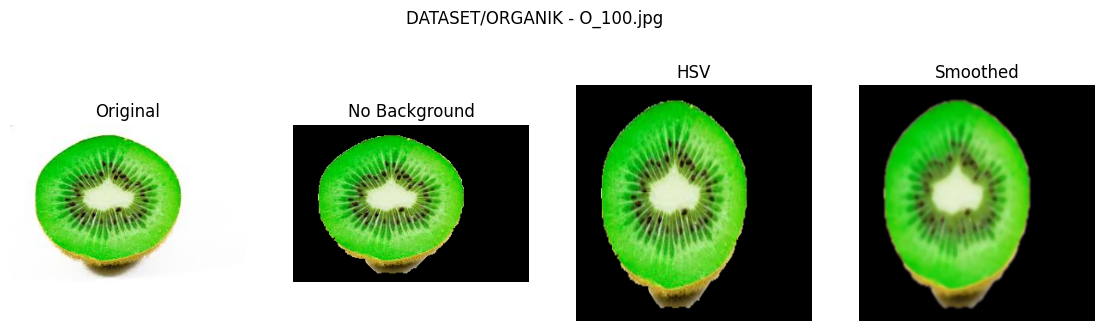

In [11]:
for cls in class_folders:
    folder_path = os.path.join(base_path, cls)
    print(f"\nKELAS: {cls}")

    # ambil hanya 3 gambar pertama untuk ditampilkan (biar tidak panjang)
    sample_images = os.listdir(folder_path)[:3]

    for img_name in sample_images:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        # 1. Remove background
        no_bg, mask = remove_background(img)

        # 2. Resize
        resized = cv2.resize(no_bg, (256, 256))

        # 3. Convert RGB ke HSV
        hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)

        # 4. Smoothing
        gaussian = cv2.GaussianBlur(hsv, (5, 5), 0)
        median = cv2.medianBlur(gaussian, 5)

        # TAMPILKAN HASIL
        plt.figure(figsize=(14, 4))
        plt.suptitle(f"{cls} - {img_name}")

        plt.subplot(1, 4, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("No Background")
        plt.imshow(cv2.cvtColor(no_bg, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("HSV")
        plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title("Smoothed")
        plt.imshow(cv2.cvtColor(median, cv2.COLOR_HSV2RGB))
        plt.axis('off')

        plt.show()

FUNGSI EKSTRAKSI FITUR

In [12]:
def extract_features(img, mask, label_class):
    # Resize dan HSV
    img = cv2.resize(img, (256, 256))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 1. Fitur Warna: Mean & Std HSV
    mean_hsv = np.mean(hsv, axis=(0,1))
    std_hsv = np.std(hsv, axis=(0,1))

    # Histogram warna (16 bin setiap channel)
    hist_h = cv2.calcHist([hsv], [0], None, [16], [0,180]).flatten()
    hist_s = cv2.calcHist([hsv], [1], None, [16], [0,256]).flatten()
    hist_v = cv2.calcHist([hsv], [2], None, [16], [0,256]).flatten()
    hist_all = np.concatenate([hist_h, hist_s, hist_v])

    # 2. Fitur Tekstur GLCM
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, "contrast")[0,0]
    correlation = graycoprops(glcm, "correlation")[0,0]
    energy = graycoprops(glcm, "energy")[0,0]
    homogeneity = graycoprops(glcm, "homogeneity")[0,0]

    # 3. Fitur Bentuk (Shape)
    region = label(mask)
    props = regionprops(region)

    if len(props) > 0:
        area = props[0].area
        perimeter = props[0].perimeter if props[0].perimeter > 0 else 1
        convex_area = props[0].convex_area

        area_ratio = area / (256*256)
        solidity = area / convex_area
        circularity = (4 * np.pi * area) / (perimeter**2)
    else:
        area_ratio = solidity = circularity = 0

    # Gabungkan semua fitur
    feature_vector = np.concatenate([
        mean_hsv, std_hsv, hist_all,
        [contrast, correlation, energy, homogeneity],
        [area_ratio, solidity, circularity]
    ])

    return feature_vector

EKSTRAKSI FITUR UNTUK SEMUA GAMBAR

In [13]:
data = []
labels = []

for cls in class_folders:
    print(f"\nEkstraksi fitur untuk kelas: {cls}")

    images = os.listdir(cls)
    images = random.sample(images, min(1500, len(images)))
    for img_name in images:
        img_path = os.path.join(cls, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Remove background
        removed, mask = remove_background(img)

        # Extract features
        feat = extract_features(removed, mask, cls)

        data.append(feat)
        labels.append(cls)

# Konversi ke DataFrame
df_features = pd.DataFrame(data)
df_features["label"] = labels

print("\nContoh Data Fitur")
df_features.head()


Ekstraksi fitur untuk kelas: DATASET/ANORGANIK

Ekstraksi fitur untuk kelas: DATASET/ORGANIK

Contoh Data Fitur


,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,label
0,6.163498,0.622772,34.602890,25.902096,4.651253,80.992126,61511.0,533.0,153.0,33.0,...,1376.0,4458.0,252.524724,0.980670,0.830239,0.874600,0.121765,0.749296,0.314329,DATASET/ANORGANIK
1,7.330994,18.025269,29.028610,23.932194,56.106593,73.788349,55544.0,2703.0,4555.0,226.0,...,1114.0,4011.0,258.590043,0.973451,0.823714,0.853205,0.061081,0.935062,0.421639,DATASET/ANORGANIK
2,0.771576,0.823792,1.473022,4.787840,9.905863,13.395176,63866.0,0.0,1642.0,13.0,...,75.0,7.0,65.129841,0.819198,0.959776,0.963274,0.001129,0.477419,0.369859,DATASET/ANORGANIK
3,2.025192,8.305862,10.386078,5.976335,27.048153,35.343222,58739.0,6035.0,762.0,0.0,...,12.0,0.0,13.637347,0.993614,0.891702,0.926994,0.079437,0.946545,0.492806,DATASET/ANORGANIK
4,26.689896,21.996567,51.093781,45.727045,47.771553,86.272294,47489.0,360.0,1277.0,331.0,...,293.0,6362.0,329.418168,0.974509,0.701910,0.833923,0.223373,0.905711,0.630375,DATASET/ANORGANIK


# KLASIFIKASI

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

Loading Data

In [16]:
BASE_DIR = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
dataset_path = os.path.join(BASE_DIR, "DATASET")

max_per_class = 1500
anorganik_all = glob.glob(os.path.join(dataset_path, "ANORGANIK", "*"))
organik_all   = glob.glob(os.path.join(dataset_path, "ORGANIK", "*"))

anorganik_sel = random.sample(anorganik_all, min(max_per_class, len(anorganik_all)))
organik_sel   = random.sample(organik_all,   min(max_per_class, len(organik_all)))

subset_df = pd.DataFrame({
    "filepath": anorganik_sel + organik_sel,
    "label":    ["ANORGANIK"]*len(anorganik_sel) + ["ORGANIK"]*len(organik_sel)
})

train_df, val_df = train_test_split(
    subset_df, test_size=0.2, stratify=subset_df["label"], random_state=42
)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col="filepath", y_col="label",
    target_size=(256, 256), batch_size=16,
    class_mode="categorical", shuffle=True
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    val_df, x_col="filepath", y_col="label",
    target_size=(256, 256), batch_size=16,
    class_mode="categorical", shuffle=False
)

print("Label Index Mapping:", train_gen.class_indices)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Label Index Mapping: {'ANORGANIK': 0, 'ORGANIK': 1}


In [28]:
print("Train samples:", len(train_df))
print("Val samples:", len(val_df))
print("Per class (train):\n", train_df['label'].value_counts())
print("Per class (val):\n", val_df['label'].value_counts())

Train samples: 2400
Val samples: 600
Per class (train):
 label
ORGANIK      1200
ANORGANIK    1200
Name: count, dtype: int64
Per class (val):
 label
ORGANIK      300
ANORGANIK    300
Name: count, dtype: int64


CNN Architecture

In [17]:
model = models.Sequential([
    # Blok 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256,256,3)),
    layers.MaxPooling2D(2,2),

    # Blok 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    # Blok 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\Aufii\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,018 (429.76 KB)

 Trainable params: 110,018 (429.76 KB)

 Non-trainable params: 0 (0.00 B)

Training

In [18]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.7104 - loss: 0.5551 - val_accuracy: 0.8117 - val_loss: 0.4214
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 430ms/step - accuracy: 0.7729 - loss: 0.4920 - val_accuracy: 0.8100 - val_loss: 0.4431
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 446ms/step - accuracy: 0.8025 - loss: 0.4529 - val_accuracy: 0.8217 - val_loss: 0.4176
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 77s 511ms/step - accuracy: 0.8108 - loss: 0.4334 - val_accuracy: 0.7950 - val_loss: 0.4488
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 76s 504ms/step - accuracy: 0.8058 - loss: 0.4368 - val_accuracy: 0.8233 - val_loss: 0.4067
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 455ms/step - accuracy: 0.8125 - loss: 0.4352 - val_accuracy: 0.8083 - val_loss: 0.3928
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 65s 435ms/step - accuracy: 0.8100 - loss: 0.4306 - val_accuracy: 0.8250 - val_loss: 0.4149
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 59s 390ms/step - accuracy: 0.8138 - loss: 0

EVALUASI MODEL 

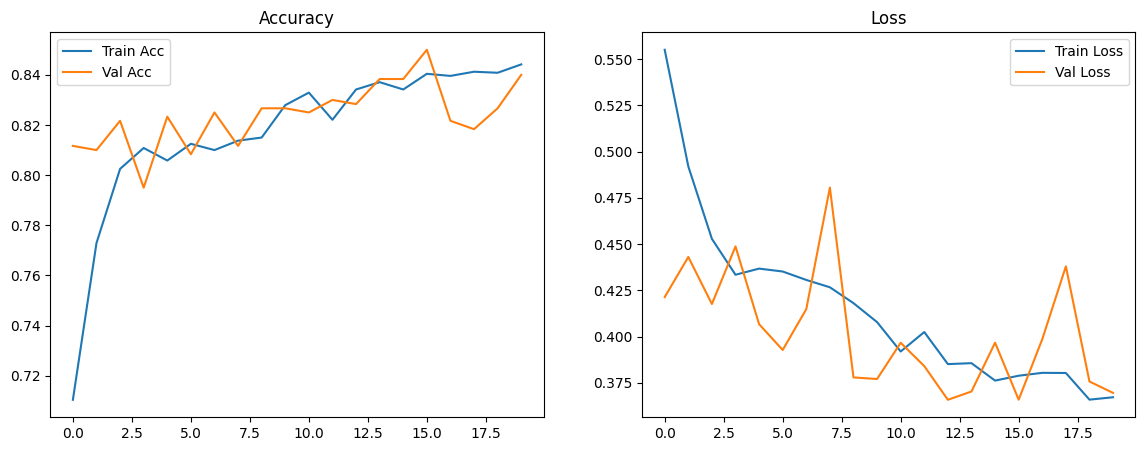

In [19]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

CONFUSION NATRIX DAN TABEL METRIK

In [20]:
y_true = []
y_pred = []

val_gen.reset()

for batch_imgs, batch_labels in val_gen:
    preds = model.predict(batch_imgs, verbose=0)

    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(batch_labels, axis=1))

    if len(y_true) >= val_gen.samples:
        break

y_true = np.array(y_true[:val_gen.samples])
y_pred = np.array(y_pred[:val_gen.samples])

class_names = list(val_gen.class_indices.keys())

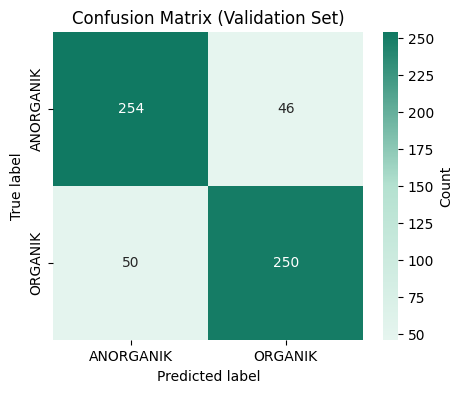

In [29]:
from matplotlib.colors import LinearSegmentedColormap

green_cmap = LinearSegmentedColormap.from_list(
    "green_custom", ["#e6f5ef", "#b4e1d0", "#107962"]
)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=green_cmap,
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Count"}
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


In [22]:
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    output_dict=True
)

df_report = pd.DataFrame(report_dict).T
df_report

,precision,recall,f1-score,support
ANORGANIK,0.835526,0.846667,0.841060,300.00
ORGANIK,0.844595,0.833333,0.838926,300.00
accuracy,0.840000,0.840000,0.840000,0.84
macro avg,0.840060,0.840000,0.839993,600.00
weighted avg,0.840060,0.840000,0.839993,600.00


PREDICTION EXAMPLES

In [23]:
class_names = list(train_gen.class_indices.keys())
anorganik_imgs = []
organik_imgs = []

In [24]:
for batch_imgs, batch_labels in val_gen:
    preds = model.predict(batch_imgs)
    pred_classes = np.argmax(preds, axis=1)

    true_classes = np.argmax(batch_labels, axis=1)

    for img, pred in zip(batch_imgs, pred_classes):
        if pred == class_names.index("ANORGANIK") and len(anorganik_imgs) < 10:
            anorganik_imgs.append((img, pred))

        if pred == class_names.index("ORGANIK") and len(organik_imgs) < 10:
            organik_imgs.append((img, pred))

        if len(anorganik_imgs) >= 10 and len(organik_imgs) >= 10:
            break
    if len(anorganik_imgs) >= 10 and len(organik_imgs) >= 10:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


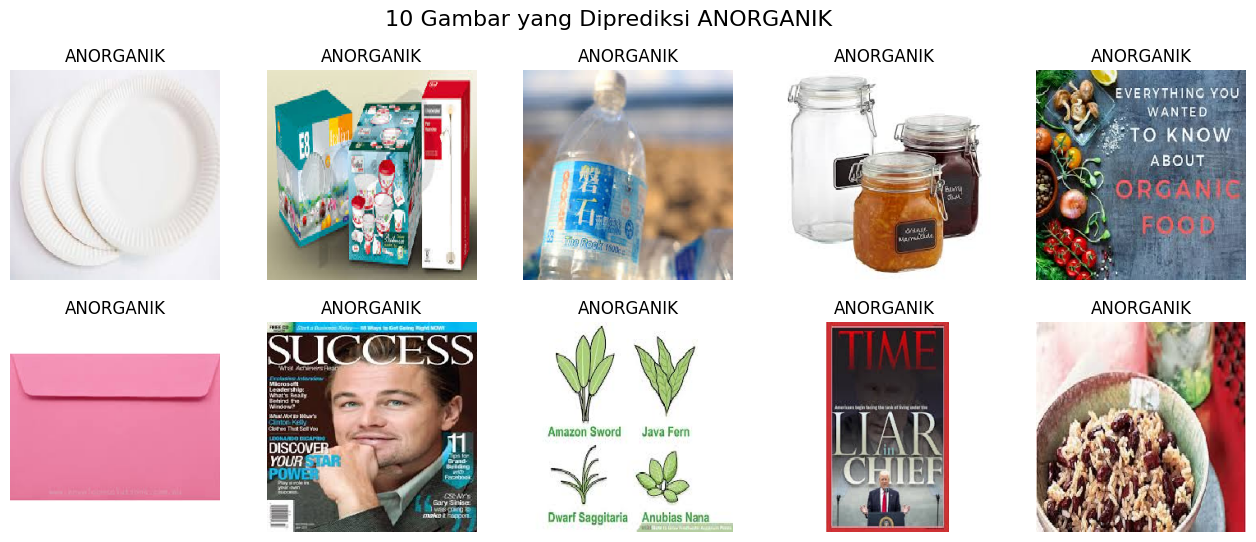

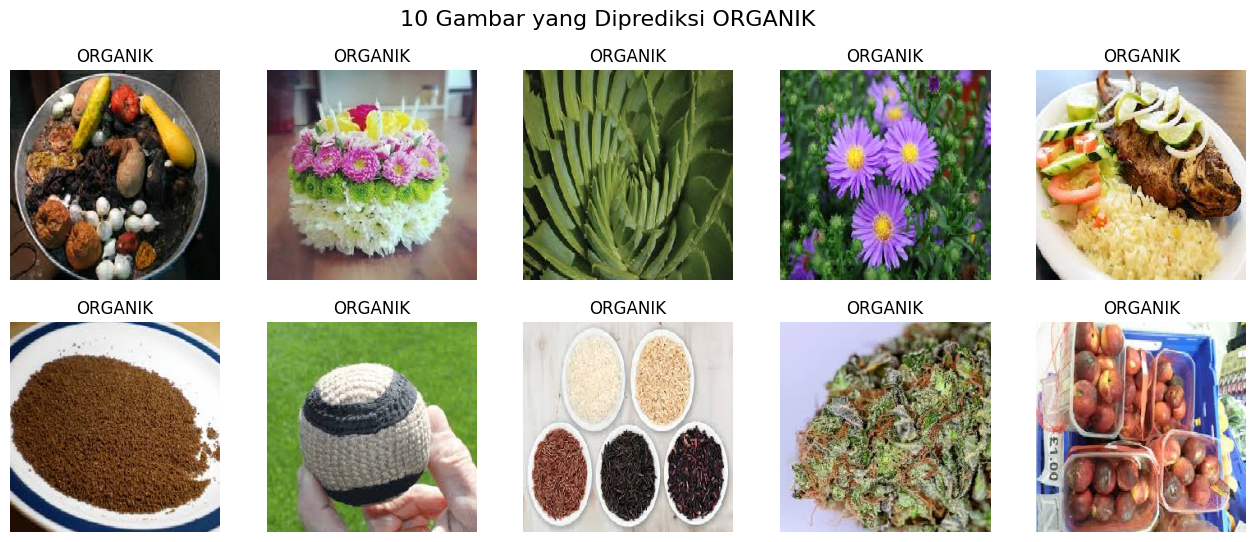

In [25]:
# TAMPILKAN ANORGANIK
plt.figure(figsize=(16, 6))
plt.suptitle("10 Gambar yang Diprediksi ANORGANIK", fontsize=16)

for i, (img, pred) in enumerate(anorganik_imgs):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(class_names[pred])
    plt.axis("off")

plt.show()

# TAMPILKAN ORGANIK
plt.figure(figsize=(16, 6))
plt.suptitle("10 Gambar yang Diprediksi ORGANIK", fontsize=16)

for i, (img, pred) in enumerate(organik_imgs):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(class_names[pred])
    plt.axis("off")

plt.show()

SINGLE PREDICTION

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Probabilitas: [[0.29533646 0.7046636 ]]
Prediksi kelas: ORGANIK


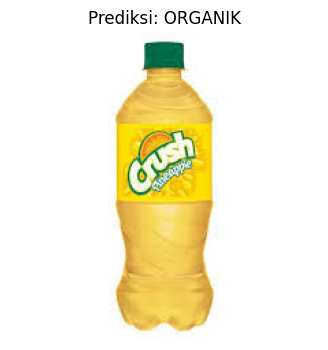

In [26]:
img_bgr = cv2.imread("r_101.jpg")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_input = cv2.resize(img_rgb, (256,256))
img_norm = img_input / 255.0
img_norm = np.expand_dims(img_norm, axis=0)

prediction = model.predict(img_norm)
class_names = list(train_gen.class_indices.keys())
pred_class = class_names[np.argmax(prediction)]

print("Probabilitas:", prediction)
print("Prediksi kelas:", pred_class)

plt.figure(figsize=(4,4))
plt.imshow(img_rgb)
plt.title(f"Prediksi: {pred_class}")
plt.axis("off")
plt.show()
